In [1]:
# Standard libraries
import os
import time
import warnings
from collections import Counter

# Data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: models, metrics, utilities
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Scikit-learn: classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Model saving
import joblib

# Warning filters
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)


## 1. Exploratory Data Analysis (EDA) 

In [2]:
# Loading the dataset
data1 = pd.read_csv('data/Monday-WorkingHours.pcap_ISCX.csv', encoding='utf-8')
data2 = pd.read_csv('data/Tuesday-WorkingHours.pcap_ISCX.csv', encoding='utf-8')
data3 = pd.read_csv('data/Wednesday-workingHours.pcap_ISCX.csv', encoding='utf-8')
data4 = pd.read_csv('data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', encoding='utf-8')
data5 = pd.read_csv('data/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', encoding='utf-8')
data6 = pd.read_csv('data/Friday-WorkingHours-Morning.pcap_ISCX.csv', encoding='utf-8')
data7 = pd.read_csv('data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', encoding='utf-8')
data8 = pd.read_csv('data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', encoding='utf-8')

In [3]:
data_list = [data1, data2, data3, data4, data5, data6, data7, data8]

print('Data dimensions: ')
for i, data in enumerate(data_list, start = 1):
  rows, cols = data.shape
  print(f'Data{i} -> {rows} rows, {cols} columns')

Data dimensions: 
Data1 -> 529918 rows, 79 columns
Data2 -> 445909 rows, 79 columns
Data3 -> 692703 rows, 79 columns
Data4 -> 170366 rows, 79 columns
Data5 -> 288602 rows, 79 columns
Data6 -> 191033 rows, 79 columns
Data7 -> 286467 rows, 79 columns
Data8 -> 225745 rows, 79 columns


In [4]:
data = pd.concat(data_list)
rows, cols = data.shape

print('New dimension:')
print(f'Number of rows: {rows}')
print(f'Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

New dimension:
Number of rows: 2830743
Number of columns: 79
Total cells: 223628697


In [5]:
# Deleting dataframes after concating to save memory
for d in data_list: del d

In [6]:
# Renaming the columns by removing leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

In [7]:
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  Flow I

In [9]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [10]:
data.head(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,49486,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,49486,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,49486,1,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,88,609,7,4,484,414,233,0,69.142857,111.967895,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,88,879,9,4,656,3064,313,0,72.888889,136.153814,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


## 2. Data Preprocessing

#### 2.1. Drop Duplicate Datas

In [11]:
dups = data[data.duplicated()]
print(f'Number of duplicates: {len(dups)}')

Number of duplicates: 308381


In [12]:
data = data.drop_duplicates()
print(f'New dataset shape after removing duplicates: {data.shape}')

New dataset shape after removing duplicates: (2522362, 79)


#### 2.2. Drop Duplicate Columns

In [13]:
col_counter = Counter(data.columns)
repeated_cols = [col for col, count in col_counter.items() if count > 1]
print("Repeated columns:", repeated_cols)

# Removing duplicated columns
if repeated_cols:
    data = data.loc[:, ~data.columns.duplicated()]


Repeated columns: []


#### 2.3. Missing and Inf Value Handling

Initial data shape: (2522362, 79)

Missing values per column (count):
Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64

Missing values per column (percentage):
Destination Port               0.0
Flow Duration                  0.0
Total Fwd Packets              0.0
Total Backward Packets         0.0
Total Length of Fwd Packets    0.0
                              ... 
Idle Mean                      0.0
Idle Std                       0.0
Idle Max                       0.0
Idle Min                       0.0
Label                          0.0
Length: 79, dtype: float64


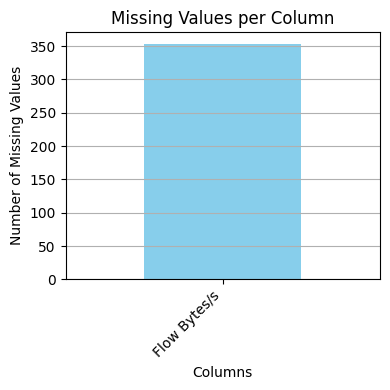


Filling missing values with median values...

Missing values after filling with median:
Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64

Data shape after filling missing values: (2522362, 79)


In [14]:
# Initial data shape
print(f"Initial data shape: {data.shape}")

# Checking missing values per column
missing_values = data.isnull().sum()
missing_values_percentage = (missing_values / len(data)) * 100

print("\nMissing values per column (count):")
print(missing_values)

print("\nMissing values per column (percentage):")
print(missing_values_percentage)

# Plotting missing values
missing_values = missing_values[missing_values > 0]  # Only columns with missing values
missing_values_percentage = missing_values_percentage[missing_values_percentage > 0]

if not missing_values.empty:
    plt.figure(figsize=(4, 4))
    missing_values.sort_values(ascending=False).plot(kind='bar', color='skyblue')
    plt.title('Missing Values per Column')
    plt.ylabel('Number of Missing Values')
    plt.xlabel('Columns')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values found. No plot needed.")

# Replacing inf values with NaN
data = data.replace([np.inf, -np.inf], np.nan)

# Checking missing values again after replacing infinities
missing_values = data.isnull().sum()
missing_values_percentage = (missing_values / len(data)) * 100

# Filling missing values with median of respective columns
print("\nFilling missing values with median values...")

for column in data.columns:
    if data[column].isnull().sum() > 0:
        median_value = data[column].median()
        data[column] = data[column].fillna(median_value)

# Checking missing values after filling
missing_values_after_filling = data.isnull().sum()

print("\nMissing values after filling with median:")
print(missing_values_after_filling)

# Verifying the data shape after filling missing values
print(f"\nData shape after filling missing values: {data.shape}")


#### 2.4. Label Corrupted Char Handling

In [15]:
unique_labels = data['Label'].unique()

print("Unique Labels:")
print(unique_labels)


Unique Labels:
['BENIGN' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris' 'DoS Slowhttptest'
 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'Web Attack � Brute Force'
 'Web Attack � XSS' 'Web Attack � Sql Injection' 'Infiltration' 'Bot'
 'PortScan' 'DDoS']


In [16]:
data['Label'] = data['Label'].replace({
    'Web Attack � Brute Force': 'Web Attack - Brute Force',
    'Web Attack � XSS': 'Web Attack - XSS',
    'Web Attack � Sql Injection': 'Web Attack - Sql Injection'
})

In [17]:
unique_labels = data['Label'].unique()

print("Unique Labels after the renaming:")
print(unique_labels)


Unique Labels after the renaming:
['BENIGN' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris' 'DoS Slowhttptest'
 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'Web Attack - Brute Force'
 'Web Attack - XSS' 'Web Attack - Sql Injection' 'Infiltration' 'Bot'
 'PortScan' 'DDoS']


#### 2.5. Dataset Distribution Visualization

Class Distribution:
Label
BENIGN                        2096484
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack - Brute Force         1470
Web Attack - XSS                  652
Infiltration                       36
Web Attack - Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


C:\Users\burakdogan\AppData\Local\Temp\ipykernel_4004\3062753500.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


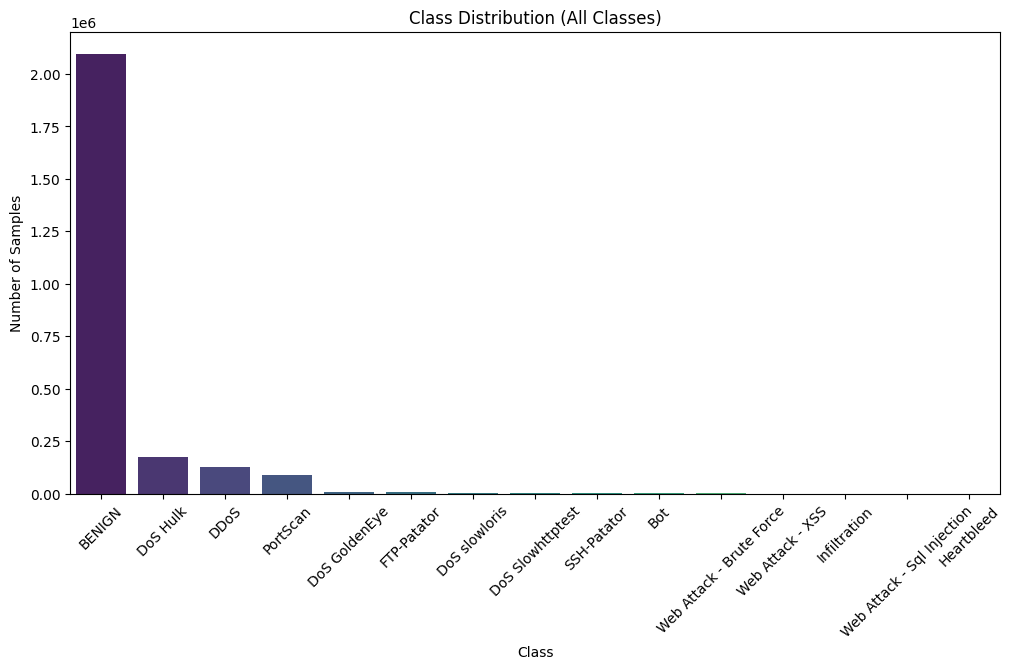

In [18]:
class_distribution = data['Label'].value_counts()
print("Class Distribution:")
print(class_distribution)

plt.figure(figsize=(12, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution (All Classes)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

Attack Type Distribution:
AttackType
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64


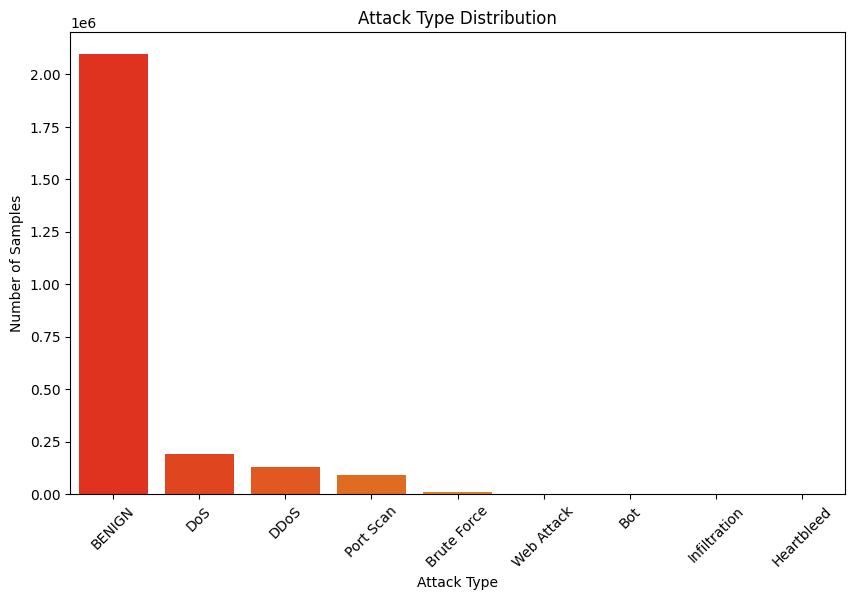

In [19]:
# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack - Brute Force': 'Web Attack',
    'Web Attack - XSS': 'Web Attack',
    'Web Attack - Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Mapping each label to its attack type
data['AttackType'] = data['Label'].map(attack_map)

# Checking the distribution of attack types
attack_type_distribution = data['AttackType'].value_counts()
print("Attack Type Distribution:")
print(attack_type_distribution)

# Plotting the distribution of attack types
plt.figure(figsize=(10, 6))
sns.barplot(x=attack_type_distribution.index, y=attack_type_distribution.values, hue=attack_type_distribution.index, palette='autumn')
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

Binary Class Distribution:
Label
BENIGN    2096484
ATTACK     425878
Name: count, dtype: int64


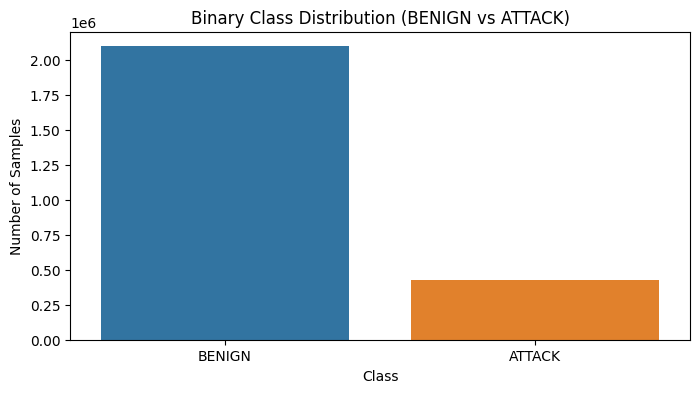

In [20]:
binary_labels = data['Label'].apply(lambda x: 'BENIGN' if x == 'BENIGN' else 'ATTACK')

binary_class_distribution = binary_labels.value_counts()
print("Binary Class Distribution:")
print(binary_class_distribution)

plt.figure(figsize=(8, 4))
sns.barplot(
    x=binary_class_distribution.index,
    y=binary_class_distribution.values,
    hue=binary_class_distribution.index,
    dodge=False
)
plt.legend([], [], frameon=False) 
plt.title('Binary Class Distribution (BENIGN vs ATTACK)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

#### 2.6. Correlation Matrix

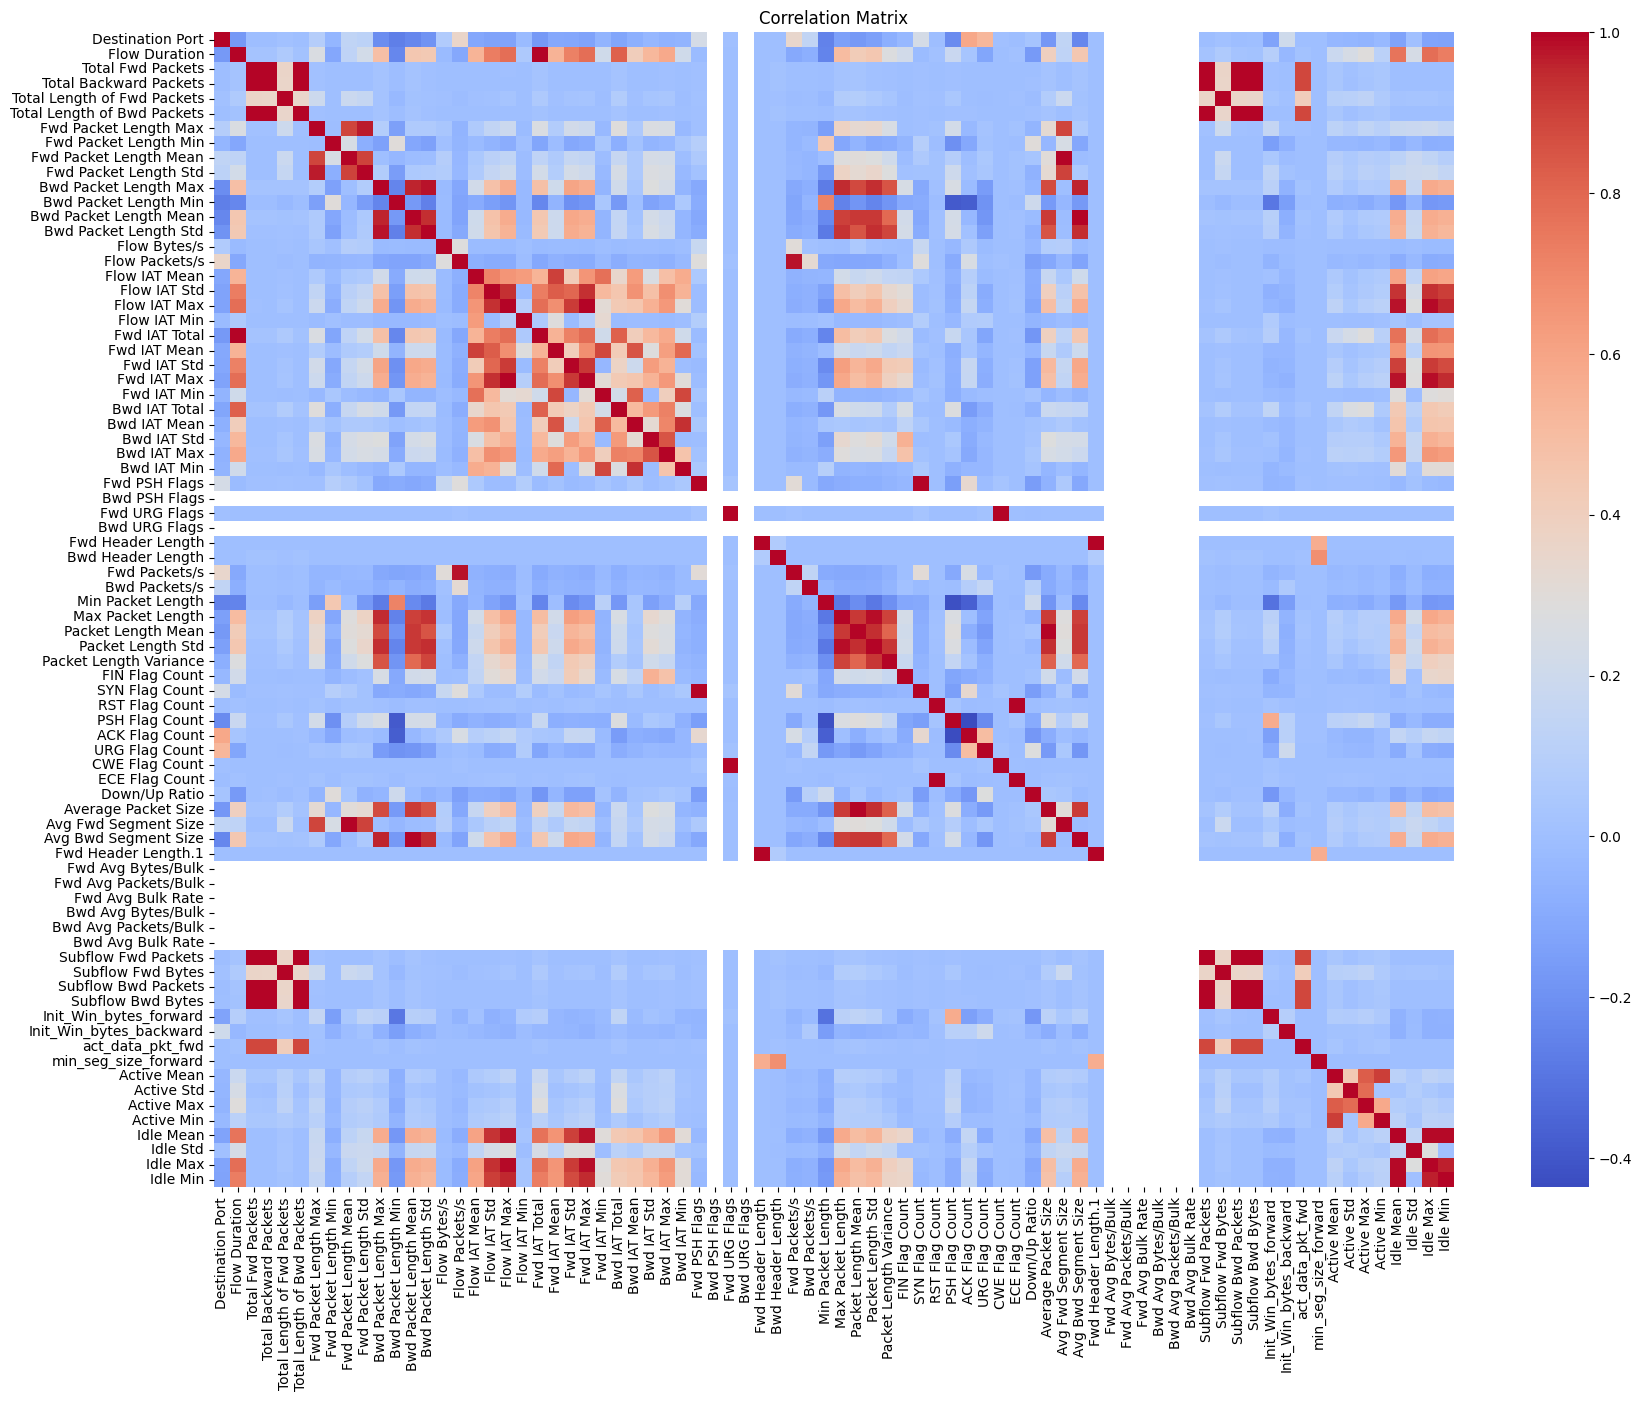

In [21]:
# Selecting numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Plotting correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(numeric_data.corr(), cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### 2.7. Feature Selection Based On Correlation

In [22]:
# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

# Select columns with correlation higher than 0.6 (absolute value)
high_corr_var = np.where(np.abs(corr_matrix) > 0.6)

# Get the pairs of features that have high correlation
high_corr_pairs = []
for i in range(len(high_corr_var[0])):
    if high_corr_var[0][i] != high_corr_var[1][i]:
        high_corr_pairs.append((numeric_data.columns[high_corr_var[0][i]], numeric_data.columns[high_corr_var[1][i]]))

# Display the highly correlated pairs
print("Highly correlated feature pairs:")
for pair in high_corr_pairs:
    print(pair)

# Drop one of each pair with high correlation (keeping the first column in each pair)
to_drop = set()
for pair in high_corr_pairs:
    to_drop.add(pair[1])  # Drop the second feature in each pair

# Removing highly correlated features from the dataset
numeric_data_reduced = numeric_data.drop(columns=to_drop)

# Displaying the shape after reduction
print(f"\nShape after feature selection: {numeric_data_reduced.shape}")


Highly correlated feature pairs:
('Flow Duration', 'Flow IAT Std')
('Flow Duration', 'Flow IAT Max')
('Flow Duration', 'Fwd IAT Total')
('Flow Duration', 'Fwd IAT Std')
('Flow Duration', 'Fwd IAT Max')
('Flow Duration', 'Bwd IAT Total')
('Flow Duration', 'Idle Mean')
('Flow Duration', 'Idle Max')
('Flow Duration', 'Idle Min')
('Total Fwd Packets', 'Total Backward Packets')
('Total Fwd Packets', 'Total Length of Bwd Packets')
('Total Fwd Packets', 'Subflow Fwd Packets')
('Total Fwd Packets', 'Subflow Bwd Packets')
('Total Fwd Packets', 'Subflow Bwd Bytes')
('Total Fwd Packets', 'act_data_pkt_fwd')
('Total Backward Packets', 'Total Fwd Packets')
('Total Backward Packets', 'Total Length of Bwd Packets')
('Total Backward Packets', 'Subflow Fwd Packets')
('Total Backward Packets', 'Subflow Bwd Packets')
('Total Backward Packets', 'Subflow Bwd Bytes')
('Total Backward Packets', 'act_data_pkt_fwd')
('Total Length of Fwd Packets', 'Subflow Fwd Bytes')
('Total Length of Bwd Packets', 'Total Fwd

In [23]:
remaining_columns = numeric_data_reduced.columns
print("Remaining columns after removing highly correlated features:")
print(remaining_columns)
print(remaining_columns.shape)

Remaining columns after removing highly correlated features:
Index(['Destination Port', 'Fwd Packet Length Min', 'Flow Bytes/s',
       'Bwd PSH Flags', 'Bwd URG Flags', 'Bwd Packets/s', 'FIN Flag Count',
       'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio',
       'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
       'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Idle Std'],
      dtype='object')
(20,)


In [24]:
numeric_data_reduced.head(10)

,Destination Port,Fwd Packet Length Min,Flow Bytes/s,Bwd PSH Flags,Bwd URG Flags,Bwd Packets/s,FIN Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,Down/Up Ratio,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Init_Win_bytes_forward,Init_Win_bytes_backward,Idle Std
0,49188,6,3.000000e+06,0,0,0.000000,0,0,1,1,0,0,0,0,0,0,0,329,-1,0.0
1,49188,6,1.200000e+07,0,0,0.000000,0,0,1,1,0,0,0,0,0,0,0,329,-1,0.0
4,49486,6,4.000000e+06,0,0,0.000000,0,0,1,1,0,0,0,0,0,0,0,245,-1,0.0
5,49486,6,1.200000e+07,0,0,0.000000,0,0,1,1,0,0,0,0,0,0,0,245,-1,0.0
8,88,0,1.474548e+06,0,0,6568.144499,0,1,0,0,0,0,0,0,0,0,0,8192,2053,0.0
9,88,0,4.232082e+06,0,0,4550.625711,0,1,0,0,0,0,0,0,0,0,0,8192,2053,0.0
10,88,0,5.329310e+06,0,0,5172.413793,0,1,0,0,0,0,0,0,0,0,0,8192,2053,0.0
11,88,0,1.074809e+07,0,0,7633.587786,0,1,0,0,0,0,0,0,0,0,0,8192,2053,0.0
12,1034,6,2.000000e+06,0,0,166666.666667,0,0,1,0,1,0,0,0,0,0,0,2053,251,0.0
13,88,0,5.558534e+06,0,0,5361.930295,0,1,0,0,0,0,0,0,0,0,0,8192,2053,0.0


## 3. Binary Classification (Attack & Benign)

#### 3.1. Data Preparing and Sampling

In [25]:
# Map detailed labels to attack categories
data['AttackType'] = data['Label'].map(attack_map)

# Filter out Infiltration and Heartbleed
valid_indices = ~data['AttackType'].isin(['Infiltration', 'Heartbleed'])
filtered_data = data[valid_indices].reset_index(drop=True)
X_filtered = numeric_data_reduced[valid_indices].reset_index(drop=True)

# Extract labels and features
y = filtered_data['AttackType']
X = X_filtered

# Create binary labels: BENIGN → 0, attacks → 1
y_binary = y.apply(lambda x: 0 if x == 'BENIGN' else 1)

# Separate benign and attack samples
X_benign = X[y_binary == 0]
y_benign = y[y_binary == 0]

X_attack = X[y_binary == 1]
y_attack = y[y_binary == 1]

# Sample 10,000 benign samples
X_benign_sampled = X_benign.sample(n=15000, random_state=42)
y_benign_sampled = y_benign.loc[X_benign_sampled.index]

# Determine balanced number of samples per attack type
attack_classes = y_attack.unique()
samples_per_class = 15000 // len(attack_classes)

# Collect attack samples equally across types
attack_samples = []
attack_labels = []

for attack_type in attack_classes:
    mask = y_attack == attack_type
    available_count = mask.sum()
    n_samples = min(samples_per_class, available_count)

    X_sampled = X_attack[mask].sample(n=n_samples, random_state=42)
    y_sampled = y_attack[mask].loc[X_sampled.index]

    attack_samples.append(X_sampled)
    attack_labels.append(y_sampled)

# Combine all sampled attack data
X_attack_sampled = pd.concat(attack_samples, axis=0)
y_attack_sampled = pd.concat(attack_labels, axis=0)

# Combine benign and attack data into a balanced dataset
X_balanced = pd.concat([X_benign_sampled, X_attack_sampled], axis=0).reset_index(drop=True)
y_balanced = pd.concat([y_benign_sampled, y_attack_sampled], axis=0).reset_index(drop=True)

# Final binary labels
y_balanced_binary = y_balanced.apply(lambda x: 0 if x == 'BENIGN' else 1)


In [26]:
# Count samples per attack category
category_counts = Counter(y_balanced)

# Compute binary label: 0 = BENIGN, 1 = ATTACK
y_balanced_binary = y_balanced.apply(lambda x: 0 if x == 'BENIGN' else 1)
binary_counts = Counter(y_balanced_binary)

# Print class distribution
print("Number of samples per attack type:")
for label, count in category_counts.items():
    print(f"   - {label:25s}: {count}")

print("Binary label distribution (Benign vs. Attack):")
for label, count in binary_counts.items():
    tag = "Benign" if label == 0 else "Attack"
    print(f"   - {tag:6s}: {count}")

print("Dataset shape:")
print(f"   - X_balanced shape: {X_balanced.shape}")


Number of samples per attack type:
   - BENIGN                   : 15000
   - Brute Force              : 2500
   - DoS                      : 2500
   - Web Attack               : 2143
   - Bot                      : 1953
   - Port Scan                : 2500
   - DDoS                     : 2500
Binary label distribution (Benign vs. Attack):
   - Benign: 15000
   - Attack: 14096
Dataset shape:
   - X_balanced shape: (29096, 20)


#### 3.2. Train Test Split

In [27]:
# Train-test split yaparken binary etiketleri kullan
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced_binary, test_size=0.2, random_state=42, stratify=y_balanced_binary
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (23276, 20) (23276,)
Test shape: (5820, 20) (5820,)


#### 3.3. Scaling

In [28]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 3.4. Visualization

In [29]:
# Print summary after scaling
print(f"\nTrain set shape: {X_train_scaled.shape}, Test set shape: {X_test_scaled.shape}")
print("\nTrain set class distribution:")
print(pd.Series(y_train).value_counts())

print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts())


Train set shape: (23276, 20), Test set shape: (5820, 20)

Train set class distribution:
AttackType
0    12000
1    11276
Name: count, dtype: int64

Test set class distribution:
AttackType
0    3000
1    2820
Name: count, dtype: int64


#### 3.4. Define Models

In [30]:
# Define models
binary_models = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
    ('SVM', SVC(C=0.5, random_state=42)),
    ('Logistic Regression', LogisticRegression(C=0.5, random_state=42, max_iter=10000)),
    ('KNN', KNeighborsClassifier(n_neighbors=5, algorithm='auto')),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5))
]

#### 3.5. Train and Compare

In [31]:
def train_and_compare(models, X_train, y_train, cv_splits=5, save_dir='model_logs', problem_type='binary'):
    """
    Generic function to train and compare models for both binary and multiclass classification
    
    Args:
        models: List of (name, model) tuples
        X_train, y_train: Training data
        cv_splits: Number of cross-validation folds
        save_dir: Directory to save results
        problem_type: 'binary' or 'multiclass'
    """
    os.makedirs(save_dir, exist_ok=True)
    results = {}
    trained_models = {}
    
    # Define scoring based on problem type
    if problem_type == 'binary':
        scoring = ['accuracy', 'f1', 'precision', 'recall']
    else:
        scoring = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']
    
    for name, model in models:
        print(f"\n{'='*50}\nEvaluating {name}\n{'='*50}")
        start_time = time.time()
        
        # Cross-validation
        cv_results = cross_validate(model, X_train, y_train, cv=cv_splits,
                                  scoring=scoring, return_train_score=False)
        
        # Extract metrics with proper key names
        metrics = {
            'accuracy': cv_results['test_accuracy'].mean(),
            'f1': cv_results[f'test_{scoring[1]}'].mean(),
            'precision': cv_results[f'test_{scoring[2]}'].mean(),
            'recall': cv_results[f'test_{scoring[3]}'].mean(),
            'train_time': time.time() - start_time
        }
        
        # Full training
        model.fit(X_train, y_train)
        trained_models[name] = model
        
        # Train set predictions
        y_pred = model.predict(X_train)
        y_proba = model.predict_proba(X_train) if hasattr(model, "predict_proba") else None
        
        # Classification report
        print(f"\nClassification Report for {name} on Train Set:")
        print(classification_report(y_train, y_pred, digits=4))
        
        # ROC Curve if available
        if y_proba is not None:
            if problem_type == 'binary':
                # Binary sınıfların isimlerini al
                class_names = np.unique(y_train)
                
                fpr, tpr, _ = roc_curve(y_train, y_proba[:, 1], pos_label=class_names[1])
                roc_auc = auc(fpr, tpr)
                
                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='blue', lw=2, 
                        label=f'ROC Curve (AUC = {roc_auc:.2f})\nPositive: {class_names[1]}')
                plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
                
                plt.xlabel(f'False Positive Rate\n(Negative: {class_names[0]})')
                plt.ylabel(f'True Positive Rate\n(Positive: {class_names[1]})')
                plt.title(f'ROC Curve - {name}')
                
                plt.legend(loc="lower right", frameon=True)
                plt.grid(True, alpha=0.3)
                
                plt.text(0.6, 0.2, f'AUC: {roc_auc:.3f}',
                        bbox=dict(facecolor='white', alpha=0.8))
                
                plt.tight_layout()
                plt.show()            
            elif problem_type == 'multiclass':
                n_classes = len(np.unique(y_train))
                if n_classes > 2:
                    classes = np.unique(y_train)
                    y_train_bin = label_binarize(y_train, classes=classes)
                    
                    fpr = dict()
                    tpr = dict()
                    roc_auc = dict()
                    
                    plt.figure(figsize=(10, 8))
                    
                    for i, class_name in enumerate(classes):
                        fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_proba[:, i])
                        roc_auc[i] = auc(fpr[i], tpr[i])
                        
                        plt.plot(fpr[i], tpr[i], 
                                label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
                    
                    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title(f'Multiclass ROC Curves - {name}')
                    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()
        
        results[name] = metrics
    
    # Comparative Analysis
    results_df = pd.DataFrame(results).T
    print("\nComparative Performance Metrics:")
    display(results_df)
    
    # Plotting comparison
    plt.figure(figsize=(12, 6))
    results_df[['accuracy', 'f1', 'precision', 'recall']].plot(kind='bar', colormap='viridis')
    plt.title('Model Comparison - Training Metrics')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df.to_csv(os.path.join(save_dir, f'{problem_type}_model_comparison.csv'))
    
    return trained_models, results_df


Evaluating Random Forest

Classification Report for Random Forest on Train Set:
              precision    recall  f1-score   support

           0     0.9997    0.9704    0.9848     12000
           1     0.9695    0.9996    0.9843     11276

    accuracy                         0.9846     23276
   macro avg     0.9846    0.9850    0.9846     23276
weighted avg     0.9850    0.9846    0.9846     23276



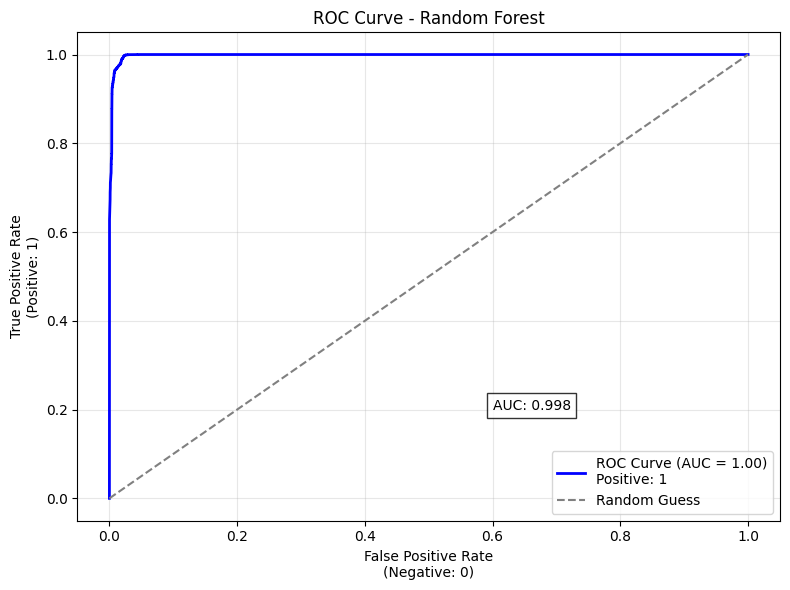


Evaluating SVM

Classification Report for SVM on Train Set:
              precision    recall  f1-score   support

           0     0.7443    0.2247    0.3452     12000
           1     0.5266    0.9179    0.6693     11276

    accuracy                         0.5605     23276
   macro avg     0.6355    0.5713    0.5072     23276
weighted avg     0.6389    0.5605    0.5022     23276


Evaluating Logistic Regression

Classification Report for Logistic Regression on Train Set:
              precision    recall  f1-score   support

           0     0.9285    0.6593    0.7711     12000
           1     0.7229    0.9460    0.8196     11276

    accuracy                         0.7982     23276
   macro avg     0.8257    0.8027    0.7953     23276
weighted avg     0.8289    0.7982    0.7946     23276



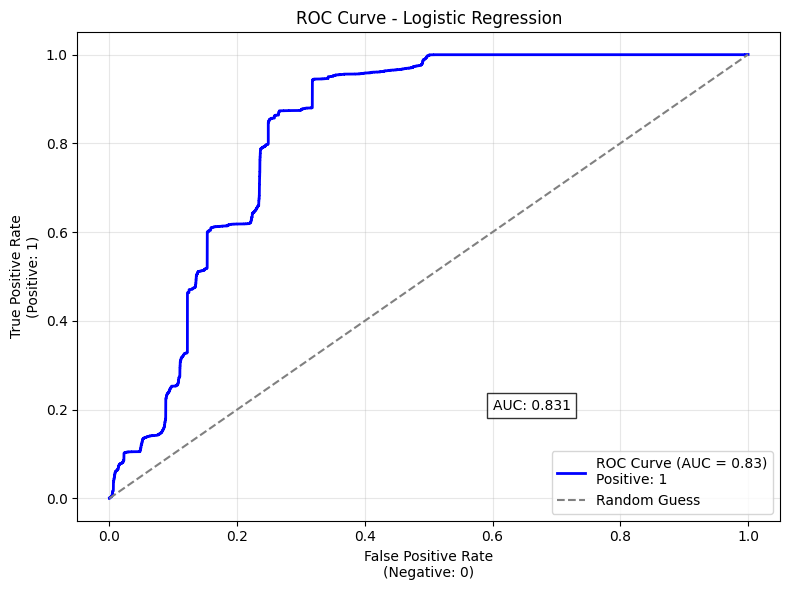


Evaluating KNN

Classification Report for KNN on Train Set:
              precision    recall  f1-score   support

           0     0.9807    0.9505    0.9653     12000
           1     0.9490    0.9800    0.9643     11276

    accuracy                         0.9648     23276
   macro avg     0.9648    0.9653    0.9648     23276
weighted avg     0.9653    0.9648    0.9648     23276



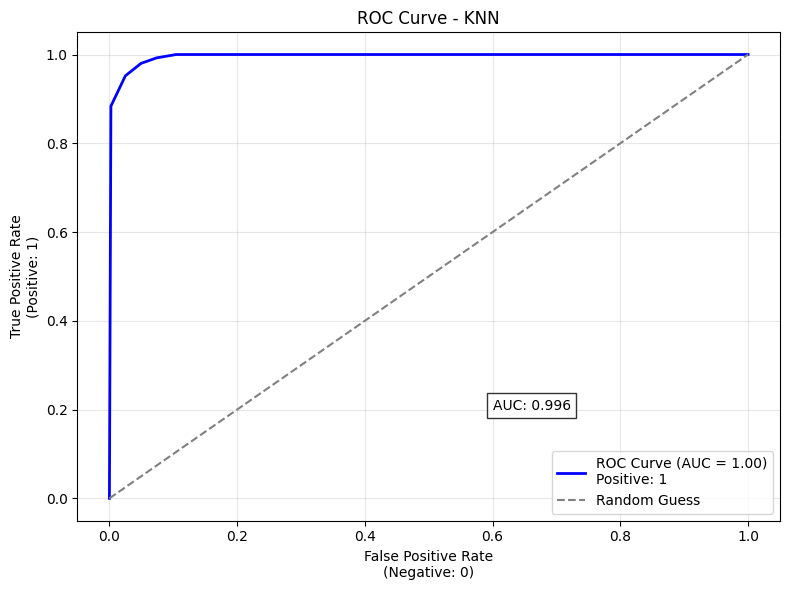


Evaluating Decision Tree

Classification Report for Decision Tree on Train Set:
              precision    recall  f1-score   support

           0     0.9954    0.9646    0.9798     12000
           1     0.9635    0.9953    0.9791     11276

    accuracy                         0.9795     23276
   macro avg     0.9795    0.9799    0.9795     23276
weighted avg     0.9800    0.9795    0.9795     23276



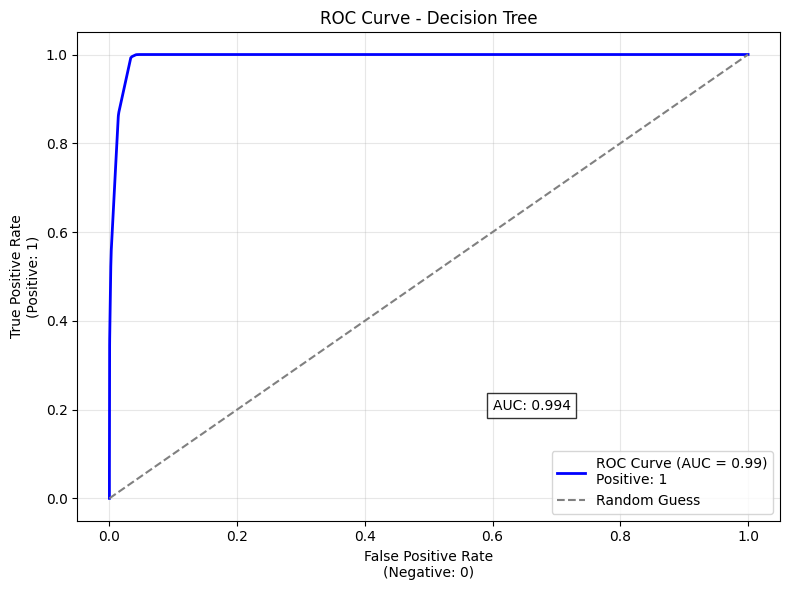


Comparative Performance Metrics:


,accuracy,f1,precision,recall,train_time
Random Forest,0.981827,0.981550,0.966014,0.997606,4.010094
SVM,0.535357,0.291260,0.700448,0.377565,63.463149
Logistic Regression,0.798247,0.819641,0.722942,0.946257,1.959786
KNN,0.948273,0.947680,0.929113,0.967009,1.097786
Decision Tree,0.977187,0.976882,0.959472,0.994945,0.232948


<Figure size 1200x600 with 0 Axes>

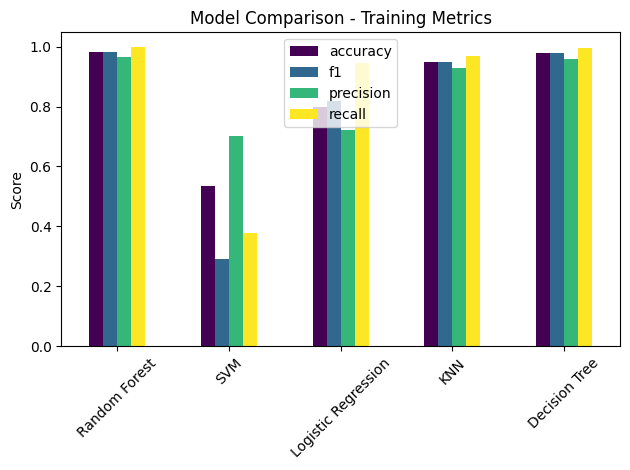

In [32]:
trained_models, results = train_and_compare(binary_models, X_train, y_train, problem_type='binary')

#### 3.6. Evaluate all binary classification models on the test set

In [33]:
def evaluate_all_on_test(trained_models, X_test, y_test, save_dir='model_logs', problem_type='binary'):
    """
    Evaluate all trained models on the test set using weighted averages for metrics.

    Args:
        trained_models: Dictionary of trained models {name: model}
        X_test, y_test: Test data
        save_dir: Directory to save results
        problem_type: 'binary' or 'multiclass'
    """
    os.makedirs(save_dir, exist_ok=True)
    test_results = {}

    for name, model in trained_models.items():
        print(f"\n{'='*60}\nEvaluating Model: {name}\n{'='*60}")
        start_time = time.time()

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
        predict_time = time.time() - start_time

        # Metrics (all weighted)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        test_results[name] = {
            'accuracy': acc,
            'f1_weighted': f1,
            'precision_weighted': precision,
            'recall_weighted': recall,
            'prediction_time': predict_time
        }

        # Classification report
        print("\nClassification Report (Weighted Averages):")
        print(classification_report(y_test, y_pred, digits=4))

        # Confusion Matrix
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

        # ROC Curve
        if y_proba is not None:
            if problem_type == 'binary':
                fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
                roc_auc = auc(fpr, tpr)

                plt.figure()
                plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'Test ROC Curve - {name}')
                plt.legend()
                plt.show()

            elif problem_type == 'multiclass':
                classes = np.unique(y_test)
                y_test_bin = label_binarize(y_test, classes=classes)
                fpr = {}
                tpr = {}
                roc_auc = {}

                plt.figure(figsize=(10, 8))
                for i in range(len(classes)):
                    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])
                    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'Multiclass ROC Curves - {name}')
                plt.legend()
                plt.grid(True)
                plt.show()

        # Feature Importances
        if hasattr(model, 'feature_importances_'):
            importances = pd.Series(model.feature_importances_, index=X_test.columns)
            importances.sort_values().plot(kind='barh', title=f'Feature Importances - {name}')
            plt.show()

    test_results_df = pd.DataFrame(test_results).T

    print("\nTest Set Performance Summary (Weighted Averages):")
    display(test_results_df)  # Pretty HTML table in Jupyter
    
    # Save results to CSV
    test_results_df.to_csv(os.path.join(save_dir, f'{problem_type}_test_results.csv'))
    
    # Plotting model comparison for test metrics
    fig, ax = plt.subplots(figsize=(12, 6))
    test_results_df[['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']].plot(
        kind='bar', 
        colormap='viridis',
        ax=ax  # çizimi bu eksen üzerine yap
    )
    ax.set_title('Model Comparison - Test Metrics (Weighted Averages)')
    ax.set_ylabel('Score')
    ax.set_xticklabels(test_results_df.index, rotation=45)
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



Evaluating Model: Random Forest

Classification Report (Weighted Averages):
              precision    recall  f1-score   support

           0     0.9990    0.9693    0.9839      3000
           1     0.9684    0.9989    0.9834      2820

    accuracy                         0.9837      5820
   macro avg     0.9837    0.9841    0.9837      5820
weighted avg     0.9841    0.9837    0.9837      5820



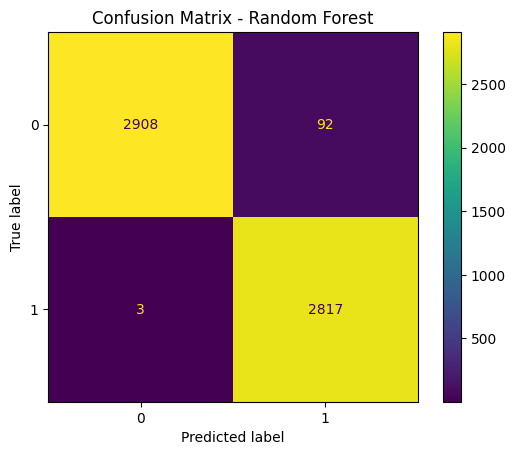

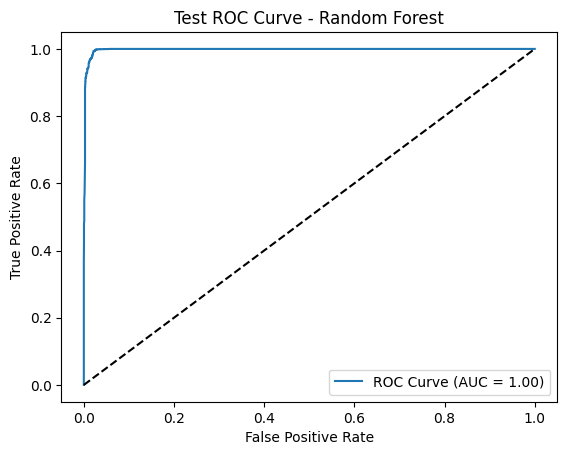

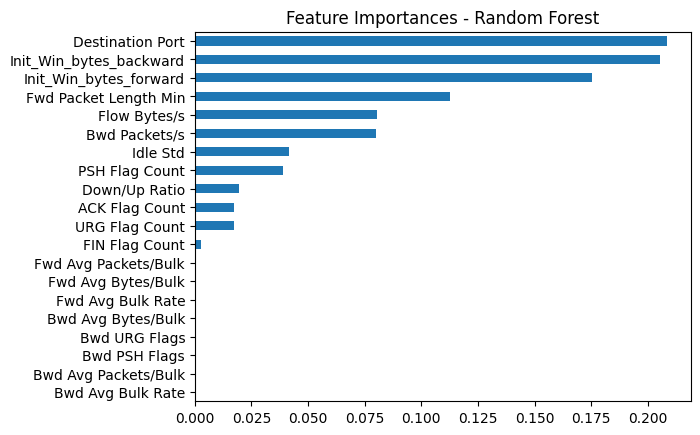


Evaluating Model: SVM

Classification Report (Weighted Averages):
              precision    recall  f1-score   support

           0     0.7256    0.2230    0.3412      3000
           1     0.5241    0.9103    0.6652      2820

    accuracy                         0.5560      5820
   macro avg     0.6248    0.5666    0.5032      5820
weighted avg     0.6280    0.5560    0.4982      5820



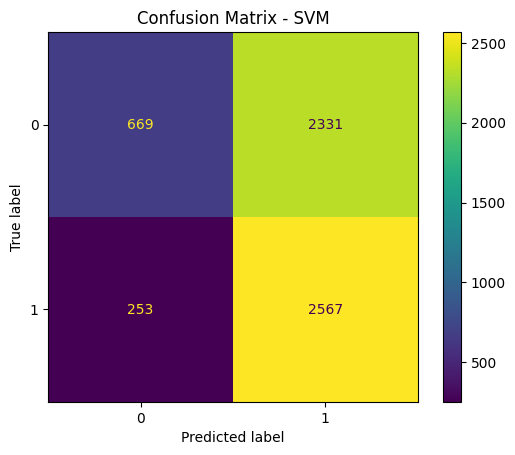


Evaluating Model: Logistic Regression

Classification Report (Weighted Averages):
              precision    recall  f1-score   support

           0     0.9255    0.6870    0.7886      3000
           1     0.7387    0.9411    0.8277      2820

    accuracy                         0.8101      5820
   macro avg     0.8321    0.8141    0.8081      5820
weighted avg     0.8349    0.8101    0.8075      5820



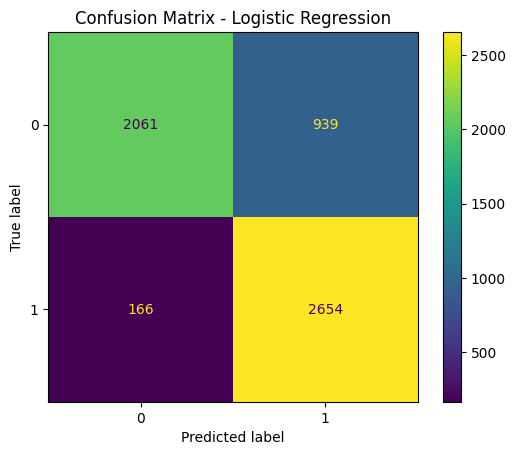

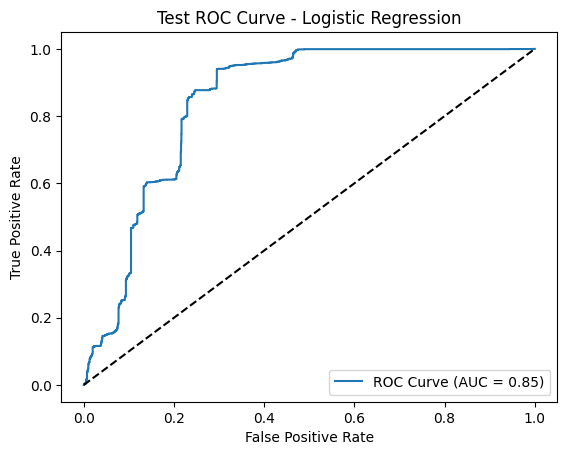


Evaluating Model: KNN

Classification Report (Weighted Averages):
              precision    recall  f1-score   support

           0     0.9684    0.9387    0.9533      3000
           1     0.9368    0.9674    0.9518      2820

    accuracy                         0.9526      5820
   macro avg     0.9526    0.9530    0.9526      5820
weighted avg     0.9531    0.9526    0.9526      5820



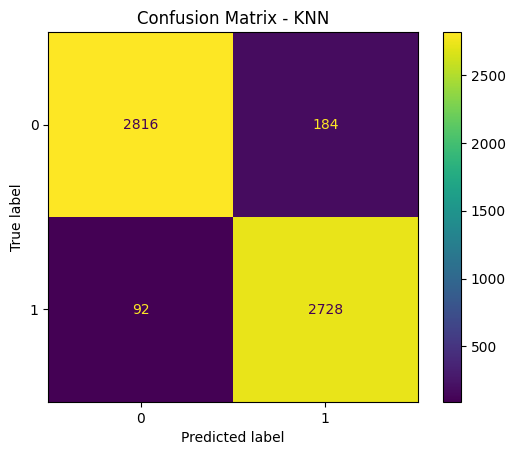

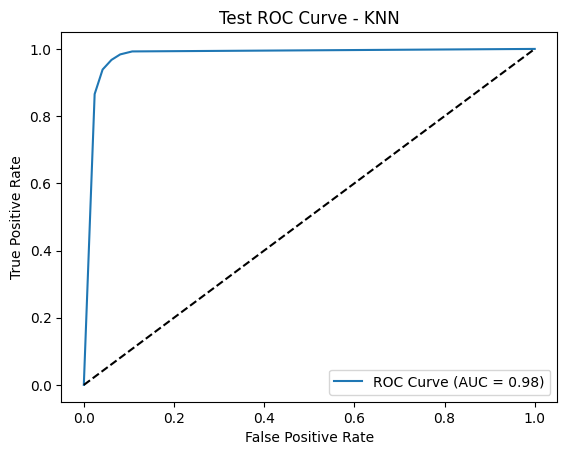


Evaluating Model: Decision Tree

Classification Report (Weighted Averages):
              precision    recall  f1-score   support

           0     0.9921    0.9600    0.9758      3000
           1     0.9589    0.9918    0.9751      2820

    accuracy                         0.9754      5820
   macro avg     0.9755    0.9759    0.9754      5820
weighted avg     0.9760    0.9754    0.9754      5820



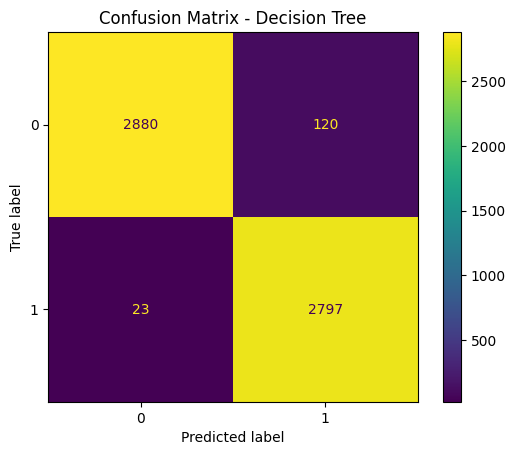

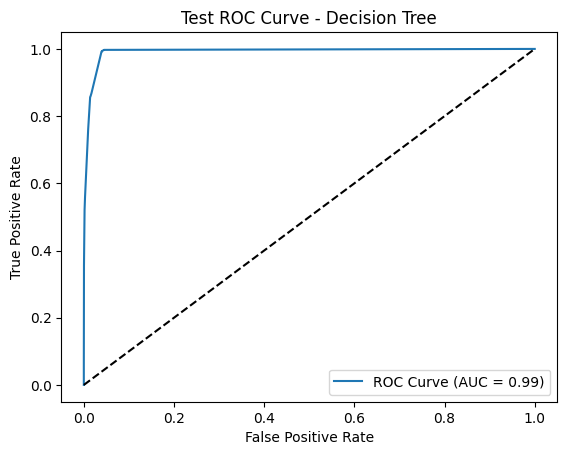

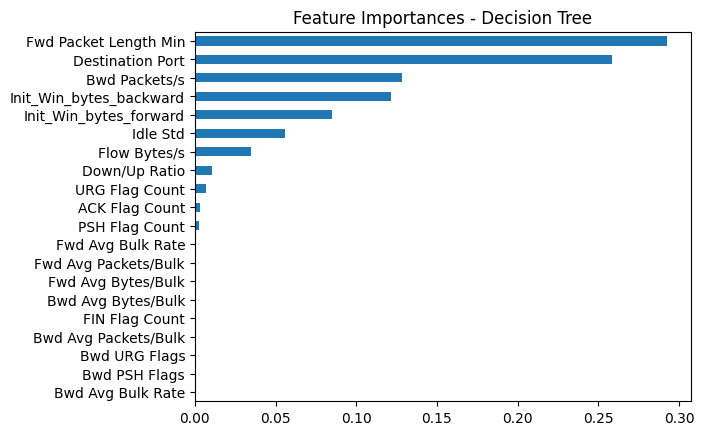


Test Set Performance Summary (Weighted Averages):


,accuracy,f1_weighted,precision_weighted,recall_weighted,prediction_time
Random Forest,0.983677,0.983681,0.984145,0.983677,0.063911
SVM,0.556014,0.498164,0.627960,0.556014,8.346297
Logistic Regression,0.810137,0.807541,0.834948,0.810137,0.002964
KNN,0.952577,0.952589,0.953076,0.952577,0.300587
Decision Tree,0.975430,0.975435,0.975983,0.975430,0.002504


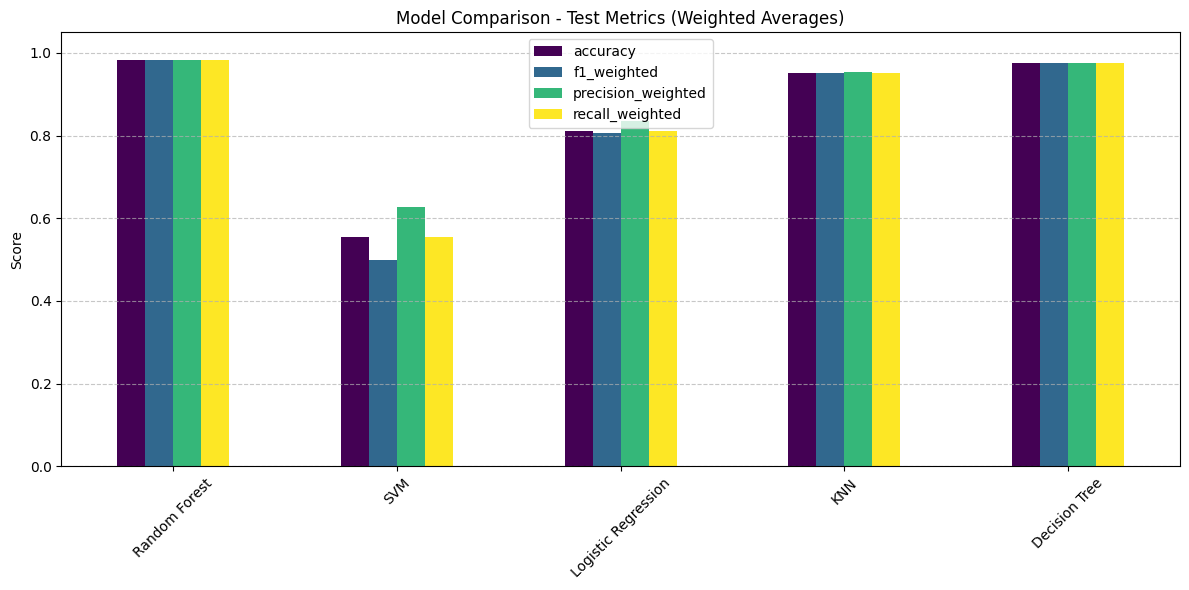

In [34]:
evaluate_all_on_test(trained_models, X_test, y_test, problem_type='binary')

## 4. Multi-class Attack Classification

#### 4.1.Prepare the Data and Split Features and Labels

In [35]:
# Create a copy of the dataset with 'AttackType' as the target column
X_all = numeric_data_reduced.copy()
X_all['AttackType'] = data['AttackType'].values  

# Filter out the 'BENIGN' class and reset the index
attack_data = X_all[X_all['AttackType'] != 'BENIGN'].reset_index(drop=True)

# İstenmeyen attack type'ları çıkar
attack_data = attack_data[~attack_data['AttackType'].isin(['Infiltration', 'Heartbleed'])]

# Özellikler (X) ve etiketler (y) olarak ayır
X_attack = attack_data.drop(columns=['AttackType'])
y_attack = attack_data['AttackType']

# Sınıf dağılımını kontrol et
print(f"X_attack shape: {X_attack.shape}")
print(f"y_attack shape: {y_attack.shape}")
print("\nFiltered AttackType distribution:")
print(y_attack.value_counts())

X_attack shape: (425831, 20)
y_attack shape: (425831,)

Filtered AttackType distribution:
AttackType
DoS            193748
DDoS           128016
Port Scan       90819
Brute Force      9152
Web Attack       2143
Bot              1953
Name: count, dtype: int64


#### 4.2. Under Sampling

In [36]:
attack_counts = y_attack.value_counts()
sampling_strategy = {}

for label, count in attack_counts.items():
    if count > 2700:
        sampling_strategy[label] = 2700
    else:
        sampling_strategy[label] = count

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_attack_balanced, y_attack_balanced = rus.fit_resample(X_attack, y_attack)

print(f"\nX_attack_balanced shape: {X_attack_balanced.shape}")
print(f"y_attack_balanced shape: {y_attack_balanced.shape}")
print("\nBalanced attack type distribution:")
print(pd.Series(y_attack_balanced).value_counts())


X_attack_balanced shape: (14896, 20)
y_attack_balanced shape: (14896,)

Balanced attack type distribution:
AttackType
Brute Force    2700
DDoS           2700
DoS            2700
Port Scan      2700
Web Attack     2143
Bot            1953
Name: count, dtype: int64


#### 4.3. Train Test Splitting

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X_attack_balanced, y_attack_balanced, 
    test_size=0.15, random_state=42, stratify=y_attack_balanced
)

#### 4.4. SMOTE for Train Class Balancing

In [38]:
smote_target_counts = {label: 2700 for label in y_train.unique()}

smote = SMOTE(sampling_strategy=smote_target_counts, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nX_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")


X_train_resampled shape: (16200, 20)
y_train_resampled shape: (16200,)


#### 4.5. Scaling

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
print(f"\nX_train_scaled shape: {X_train.shape}, X_test_scaled shape: {X_test.shape}")



X_train_scaled shape: (12661, 20), X_test_scaled shape: (2235, 20)


In [40]:
print("\nTrain set class distribution:")
print(pd.Series(y_train_resampled).value_counts())

print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts())


Train set class distribution:
AttackType
Port Scan      2700
Web Attack     2700
Bot            2700
DDoS           2700
Brute Force    2700
DoS            2700
Name: count, dtype: int64

Test set class distribution:
AttackType
Brute Force    405
DoS            405
DDoS           405
Port Scan      405
Web Attack     322
Bot            293
Name: count, dtype: int64


#### 4.6. Visualization

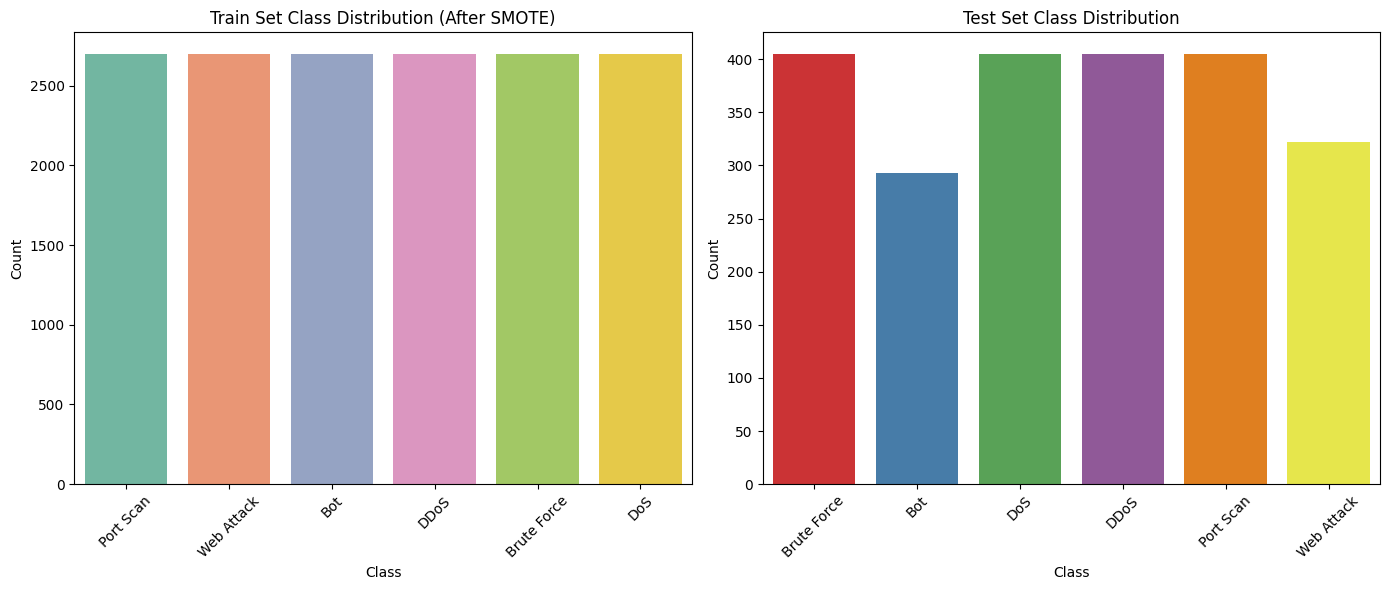

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x=y_train_resampled, ax=axes[0], hue=y_train_resampled, palette='Set2')
axes[0].set_title("Train Set Class Distribution (After SMOTE)")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(x=y_test, ax=axes[1], hue=y_test, palette='Set1')
axes[1].set_title("Test Set Class Distribution")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### 4.6. Define the Models

In [42]:
multiclass_models = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
    ('SVM', SVC(C=0.5, random_state=42, max_iter=10000)),
    ('Logistic Regression', LogisticRegression(C=0.5, max_iter=10000)),
    ('KNN', KNeighborsClassifier(n_neighbors=5, algorithm='auto')),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)),
    ('AdaBoostClassifier',AdaBoostClassifier(n_estimators=100, random_state=42))
]

#### 4.7. Train and Compare


Evaluating Random Forest

Classification Report for Random Forest on Train Set:
              precision    recall  f1-score   support

         Bot     1.0000    1.0000    1.0000      2700
 Brute Force     1.0000    1.0000    1.0000      2700
        DDoS     1.0000    1.0000    1.0000      2700
         DoS     0.9989    1.0000    0.9994      2700
   Port Scan     1.0000    0.9993    0.9996      2700
  Web Attack     1.0000    0.9996    0.9998      2700

    accuracy                         0.9998     16200
   macro avg     0.9998    0.9998    0.9998     16200
weighted avg     0.9998    0.9998    0.9998     16200



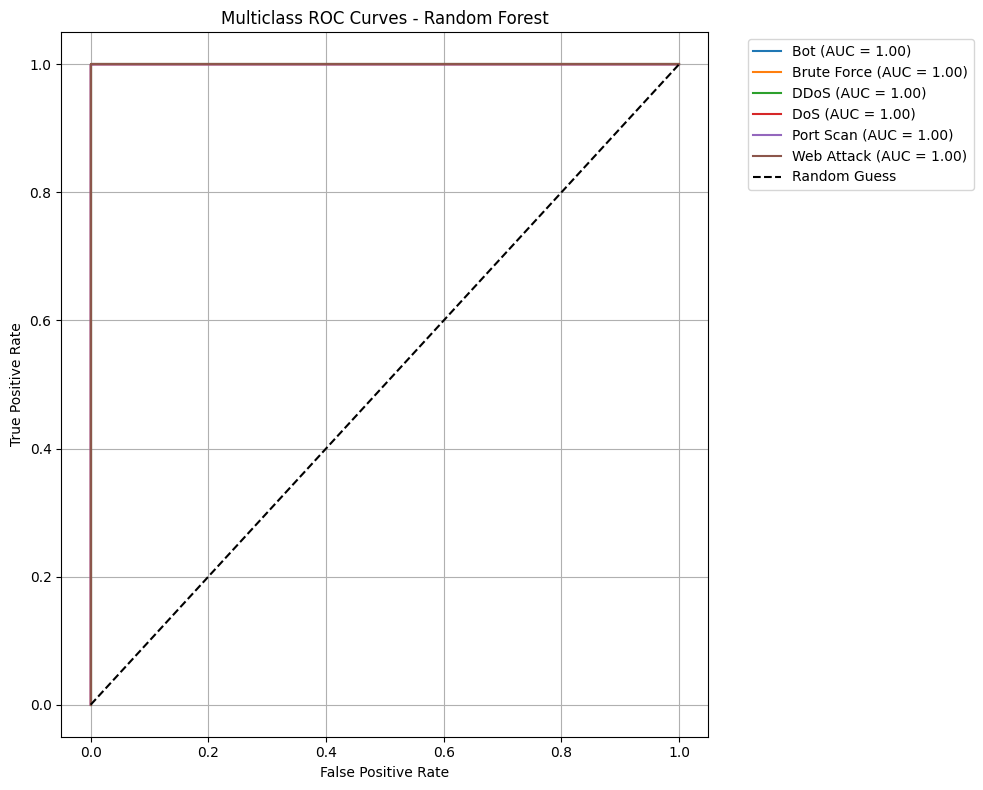


Evaluating SVM

Classification Report for SVM on Train Set:
              precision    recall  f1-score   support

         Bot     0.7857    0.0326    0.0626      2700
 Brute Force     0.0142    0.0015    0.0027      2700
        DDoS     0.8853    0.0915    0.1658      2700
         DoS     1.0000    0.0319    0.0617      2700
   Port Scan     0.4517    0.3652    0.4039      2700
  Web Attack     0.2036    1.0000    0.3384      2700

    accuracy                         0.2538     16200
   macro avg     0.5568    0.2538    0.1725     16200
weighted avg     0.5568    0.2538    0.1725     16200


Evaluating Logistic Regression

Classification Report for Logistic Regression on Train Set:
              precision    recall  f1-score   support

         Bot     0.4359    0.9996    0.6071      2700
 Brute Force     0.8278    0.9630    0.8903      2700
        DDoS     0.7994    0.0915    0.1642      2700
         DoS     0.0614    0.0326    0.0426      2700
   Port Scan     0.9724    0.938

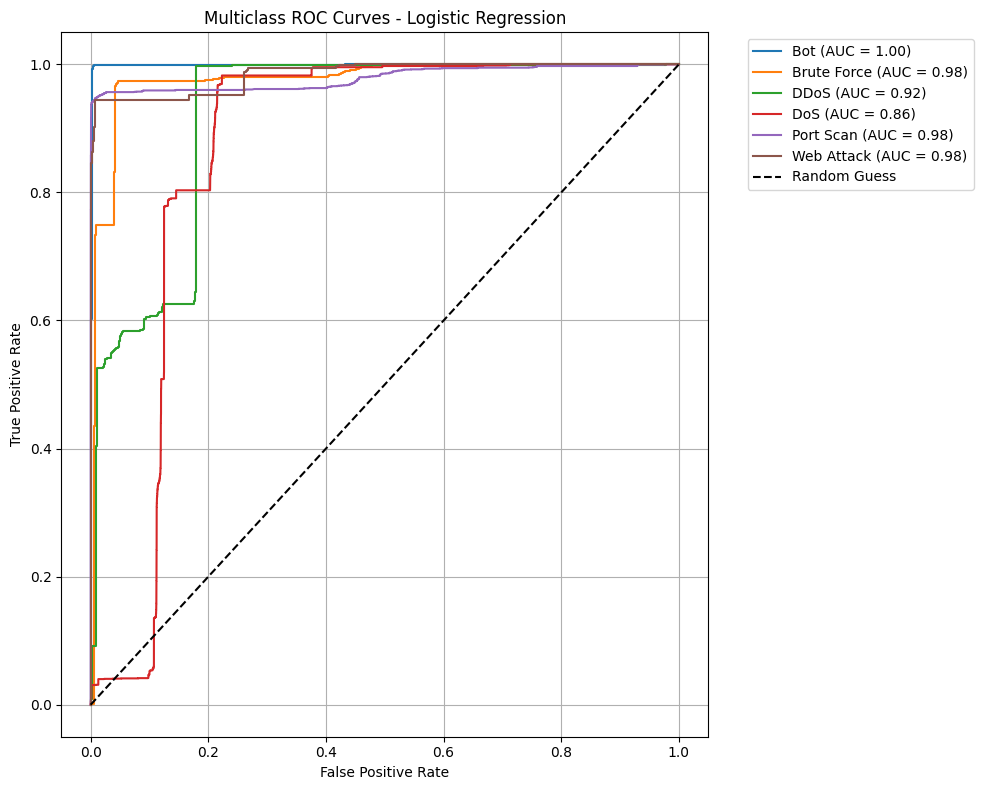


Evaluating KNN

Classification Report for KNN on Train Set:
              precision    recall  f1-score   support

         Bot     0.9831    0.9911    0.9871      2700
 Brute Force     0.9951    0.9785    0.9867      2700
        DDoS     0.9860    0.9922    0.9891      2700
         DoS     0.9826    0.9848    0.9837      2700
   Port Scan     0.9926    0.9885    0.9905      2700
  Web Attack     0.9886    0.9926    0.9906      2700

    accuracy                         0.9880     16200
   macro avg     0.9880    0.9880    0.9880     16200
weighted avg     0.9880    0.9880    0.9880     16200



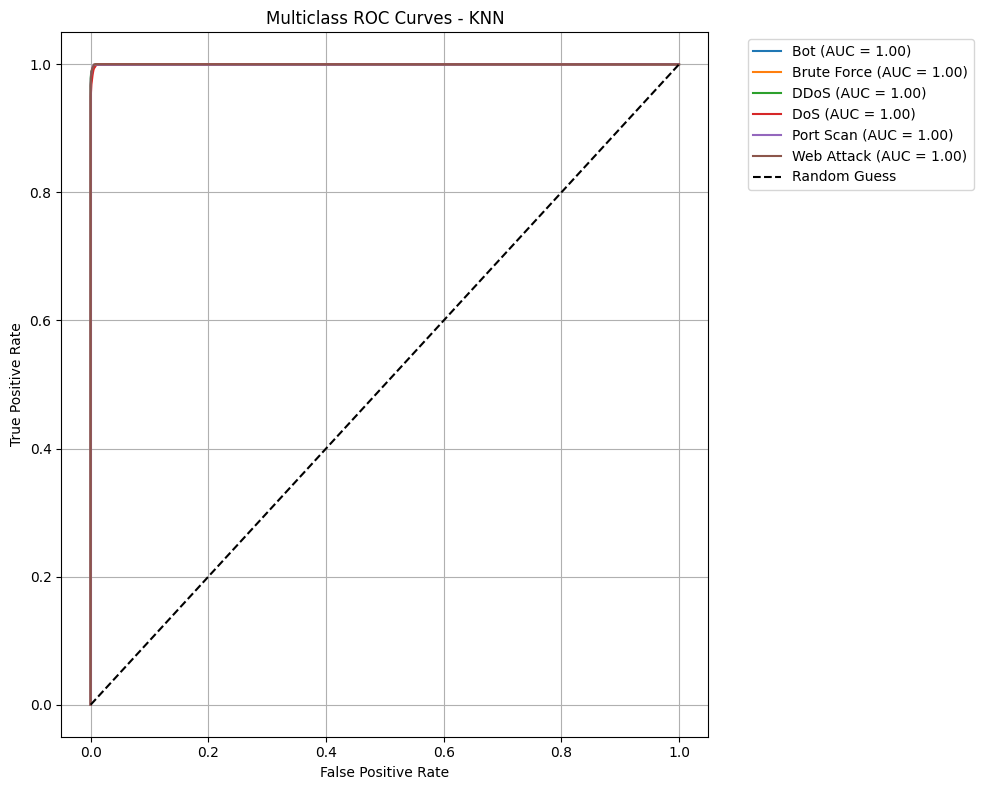


Evaluating Decision Tree

Classification Report for Decision Tree on Train Set:
              precision    recall  f1-score   support

         Bot     1.0000    1.0000    1.0000      2700
 Brute Force     1.0000    1.0000    1.0000      2700
        DDoS     0.9941    1.0000    0.9970      2700
         DoS     0.9993    0.9937    0.9965      2700
   Port Scan     1.0000    0.9993    0.9996      2700
  Web Attack     0.9996    1.0000    0.9998      2700

    accuracy                         0.9988     16200
   macro avg     0.9988    0.9988    0.9988     16200
weighted avg     0.9988    0.9988    0.9988     16200



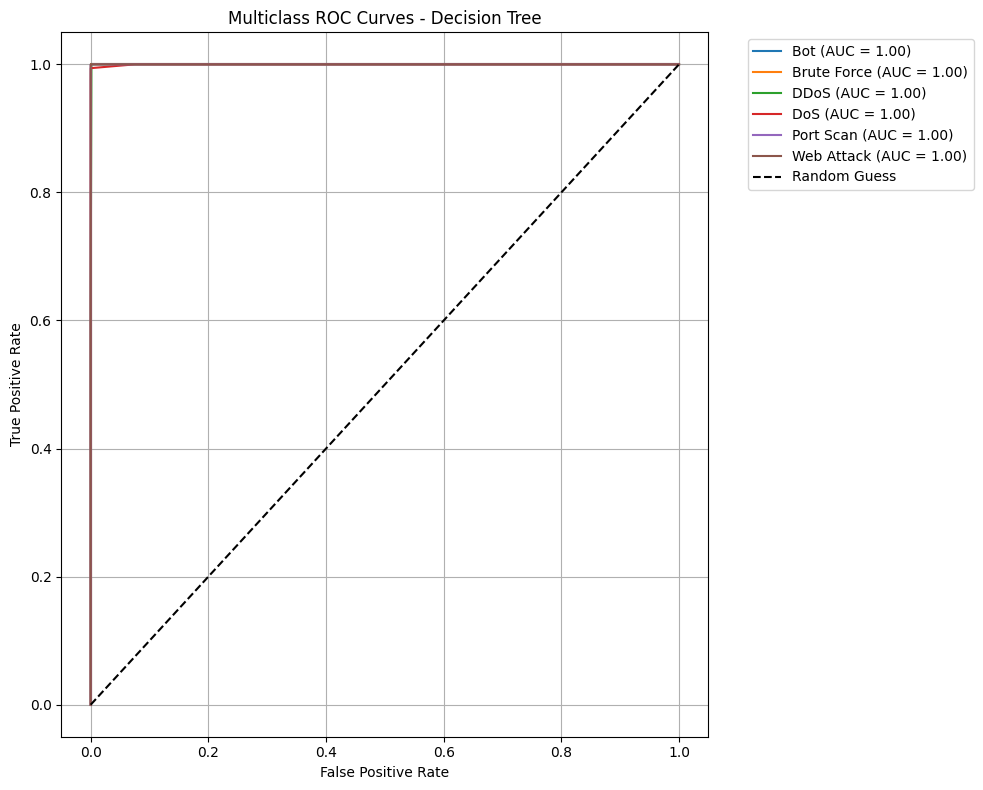


Evaluating AdaBoostClassifier

Classification Report for AdaBoostClassifier on Train Set:
              precision    recall  f1-score   support

         Bot     0.8735    1.0000    0.9325      2700
 Brute Force     0.9934    1.0000    0.9967      2700
        DDoS     0.9849    0.8207    0.8954      2700
         DoS     0.7799    0.9830    0.8697      2700
   Port Scan     0.9987    0.8463    0.9162      2700
  Web Attack     0.9955    0.9033    0.9472      2700

    accuracy                         0.9256     16200
   macro avg     0.9376    0.9256    0.9263     16200
weighted avg     0.9376    0.9256    0.9263     16200



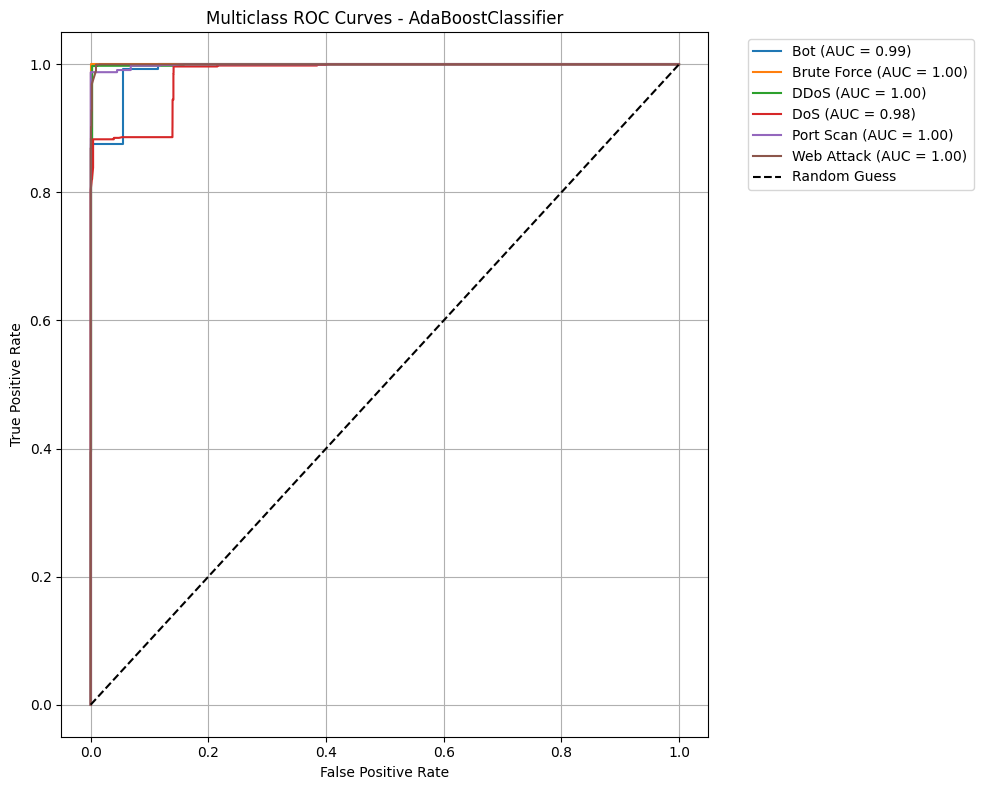


Comparative Performance Metrics:


,accuracy,f1,precision,recall,train_time
Random Forest,0.998765,0.998766,0.998770,0.998765,2.569767
SVM,0.239691,0.159402,0.541292,0.239691,45.235007
Logistic Regression,0.653025,0.590858,0.661521,0.653025,106.111043
KNN,0.979383,0.979376,0.979463,0.979383,0.733690
Decision Tree,0.997099,0.997096,0.997113,0.997099,0.260327
AdaBoostClassifier,0.943827,0.943781,0.951526,0.943827,6.508211


<Figure size 1200x600 with 0 Axes>

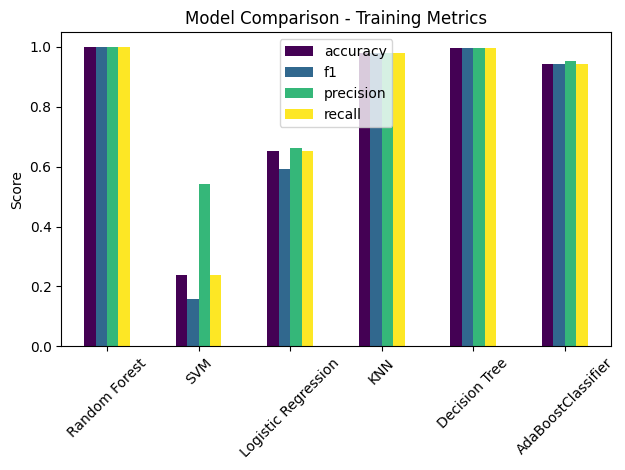

In [43]:
trained_models, results = train_and_compare(multiclass_models, X_train_resampled, y_train_resampled, problem_type='multiclass')

#### 4.8. Evaluate all multiclass classification models on the test set


Evaluating Model: Random Forest

Classification Report (Weighted Averages):
              precision    recall  f1-score   support

         Bot     1.0000    1.0000    1.0000       293
 Brute Force     1.0000    0.9975    0.9988       405
        DDoS     1.0000    1.0000    1.0000       405
         DoS     0.9975    1.0000    0.9988       405
   Port Scan     1.0000    0.9975    0.9988       405
  Web Attack     0.9969    1.0000    0.9984       322

    accuracy                         0.9991      2235
   macro avg     0.9991    0.9992    0.9991      2235
weighted avg     0.9991    0.9991    0.9991      2235



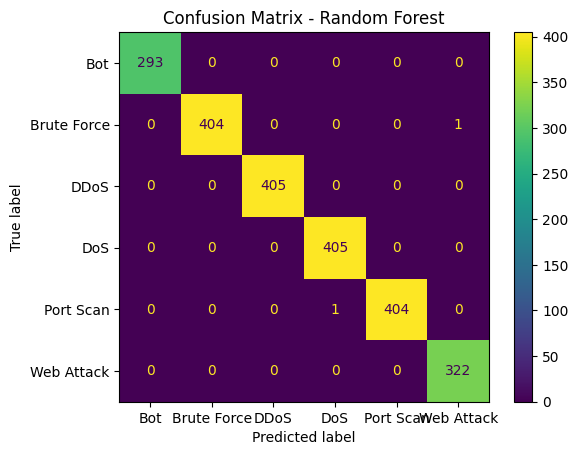

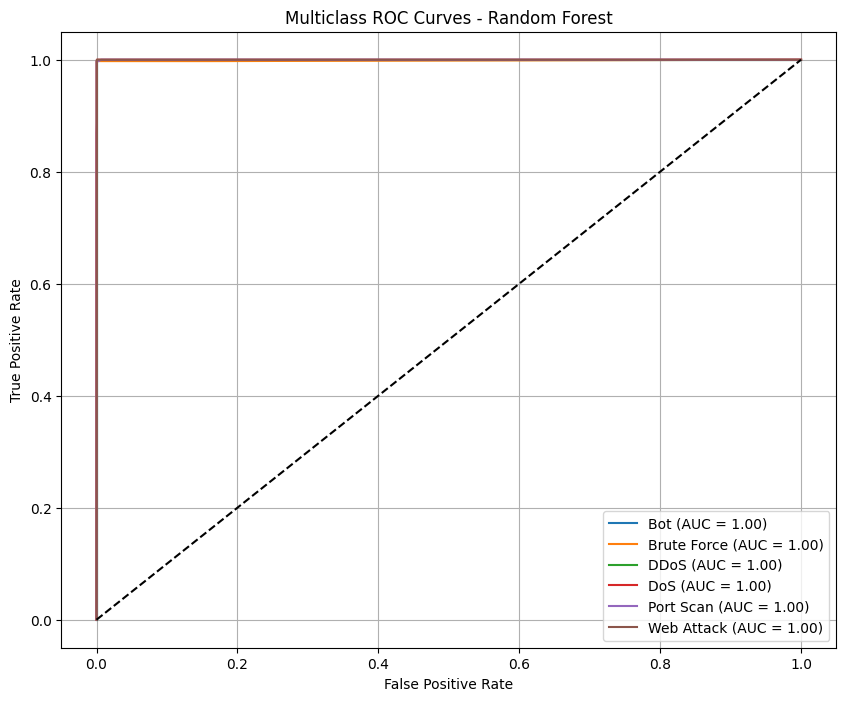

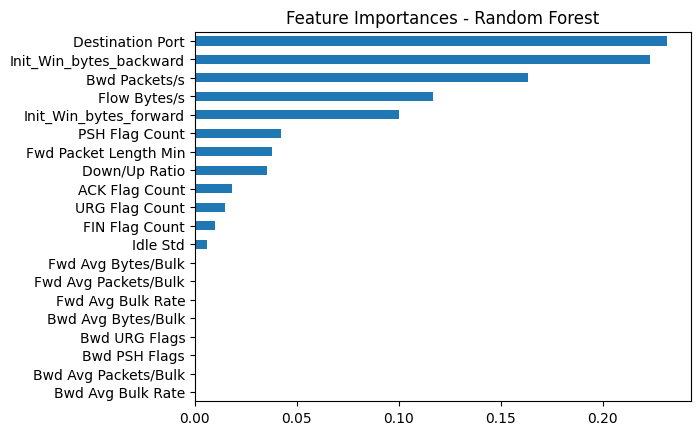


Evaluating Model: SVM

Classification Report (Weighted Averages):
              precision    recall  f1-score   support

         Bot     0.7000    0.0239    0.0462       293
 Brute Force     0.0000    0.0000    0.0000       405
        DDoS     0.9000    0.1111    0.1978       405
         DoS     1.0000    0.0247    0.0482       405
   Port Scan     0.5552    0.3975    0.4633       405
  Web Attack     0.1749    1.0000    0.2977       322

    accuracy                         0.2438      2235
   macro avg     0.5550    0.2595    0.1755      2235
weighted avg     0.5619    0.2438    0.1775      2235



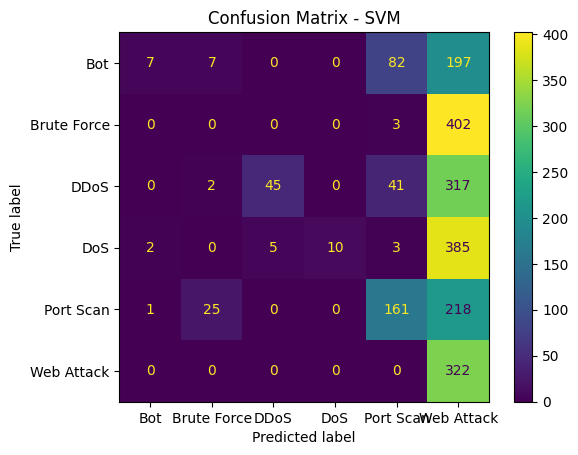


Evaluating Model: Logistic Regression

Classification Report (Weighted Averages):
              precision    recall  f1-score   support

         Bot     0.3560    1.0000    0.5251       293
 Brute Force     0.8641    0.9580    0.9087       405
        DDoS     0.8036    0.1111    0.1952       405
         DoS     0.0476    0.0247    0.0325       405
   Port Scan     0.9895    0.9309    0.9593       405
  Web Attack     0.9462    0.9286    0.9373       322

    accuracy                         0.6318      2235
   macro avg     0.6678    0.6589    0.5930      2235
weighted avg     0.6731    0.6318    0.5836      2235



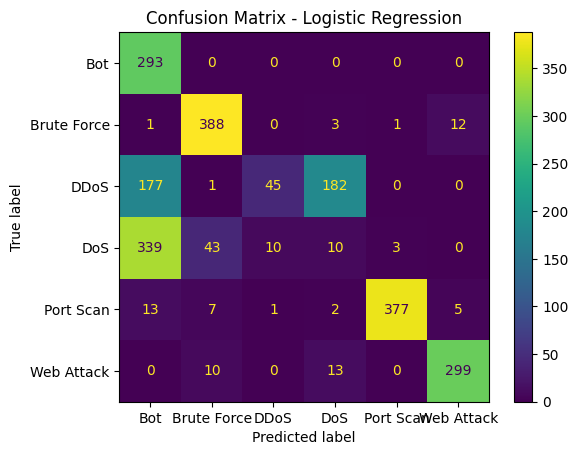

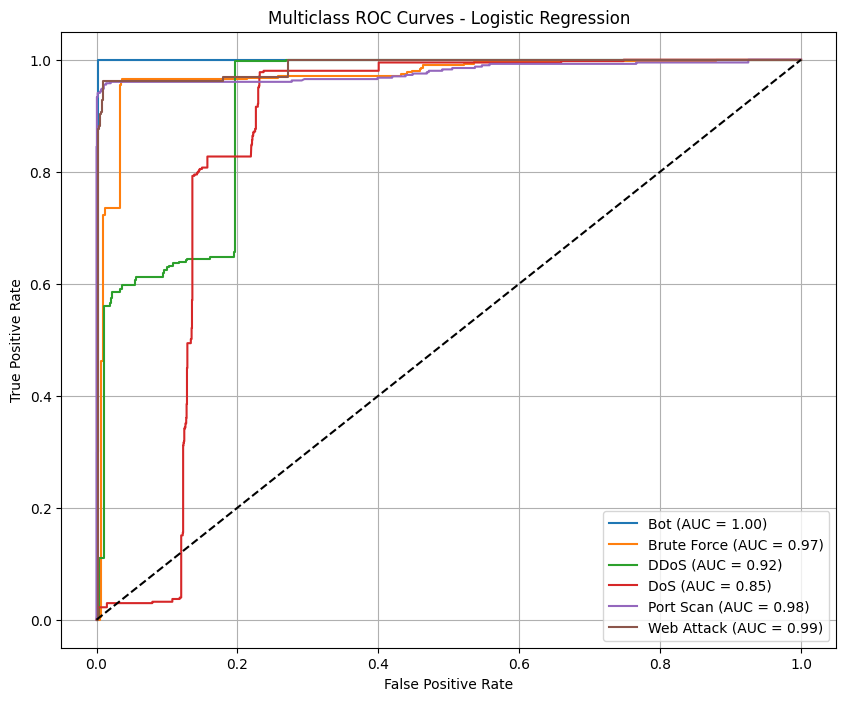


Evaluating Model: KNN

Classification Report (Weighted Averages):
              precision    recall  f1-score   support

         Bot     0.9498    0.9693    0.9595       293
 Brute Force     0.9949    0.9679    0.9812       405
        DDoS     0.9877    0.9877    0.9877       405
         DoS     0.9728    0.9728    0.9728       405
   Port Scan     0.9777    0.9728    0.9752       405
  Web Attack     0.9726    0.9938    0.9831       322

    accuracy                         0.9772      2235
   macro avg     0.9759    0.9774    0.9766      2235
weighted avg     0.9774    0.9772    0.9772      2235



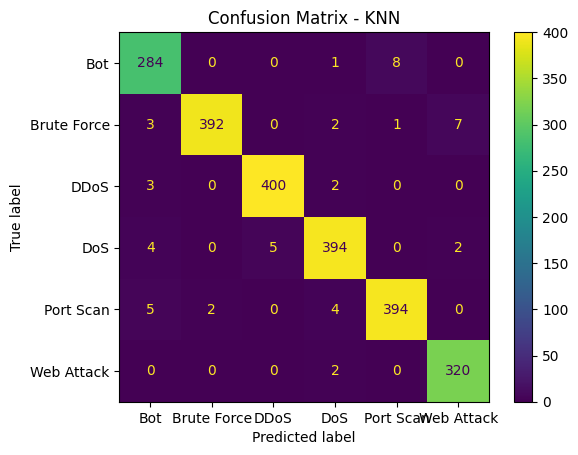

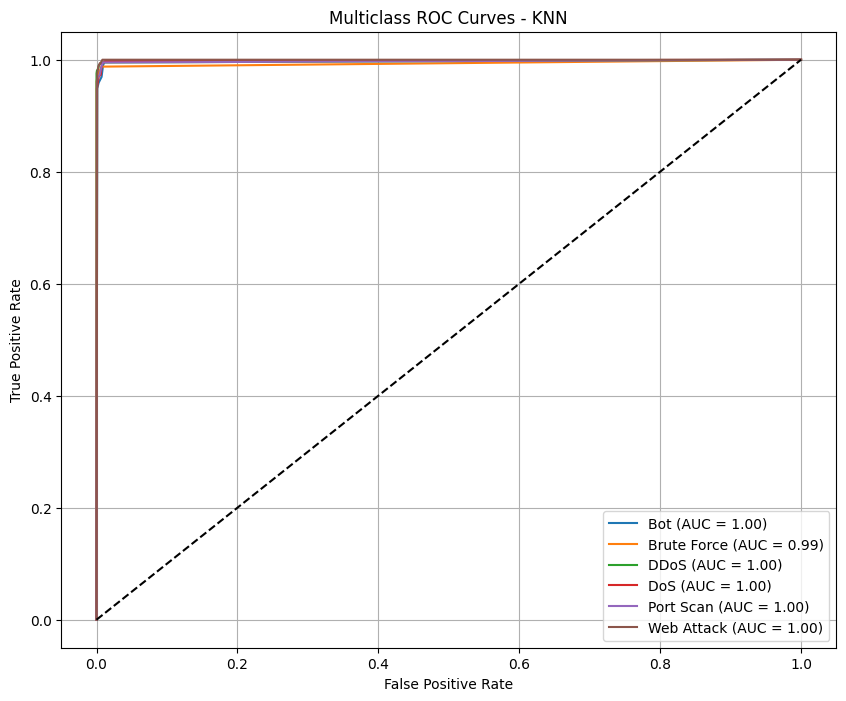


Evaluating Model: Decision Tree

Classification Report (Weighted Averages):
              precision    recall  f1-score   support

         Bot     1.0000    1.0000    1.0000       293
 Brute Force     1.0000    0.9975    0.9988       405
        DDoS     0.9902    1.0000    0.9951       405
         DoS     0.9975    0.9901    0.9938       405
   Port Scan     1.0000    0.9975    0.9988       405
  Web Attack     0.9969    1.0000    0.9984       322

    accuracy                         0.9973      2235
   macro avg     0.9974    0.9975    0.9975      2235
weighted avg     0.9973    0.9973    0.9973      2235



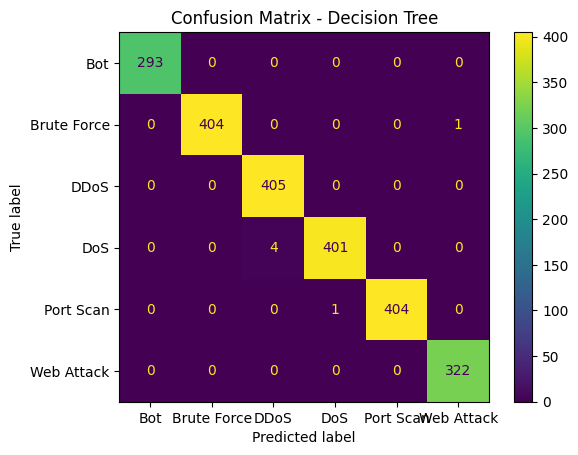

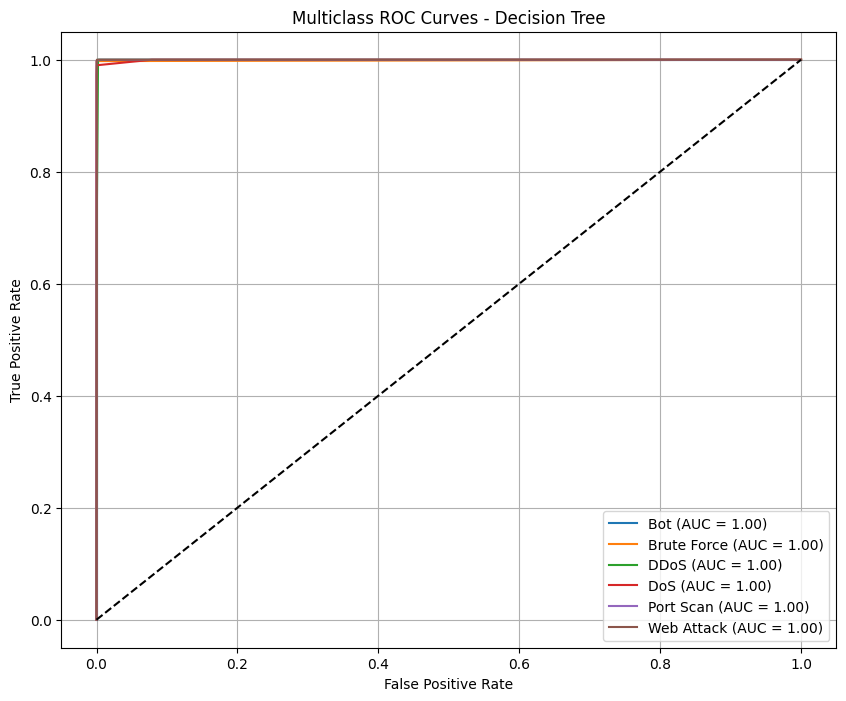

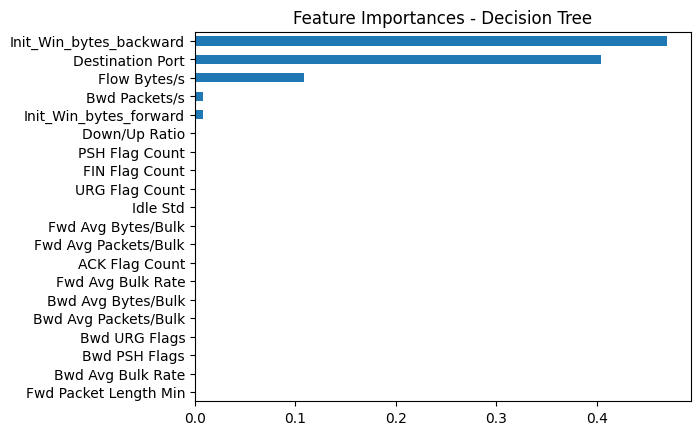


Evaluating Model: AdaBoostClassifier

Classification Report (Weighted Averages):
              precision    recall  f1-score   support

         Bot     0.8367    0.9966    0.9097       293
 Brute Force     0.9902    0.9975    0.9938       405
        DDoS     0.9767    0.8272    0.8957       405
         DoS     0.8082    0.9778    0.8849       405
   Port Scan     0.9942    0.8469    0.9147       405
  Web Attack     0.9967    0.9286    0.9614       322

    accuracy                         0.9257      2235
   macro avg     0.9338    0.9291    0.9267      2235
weighted avg     0.9363    0.9257    0.9263      2235



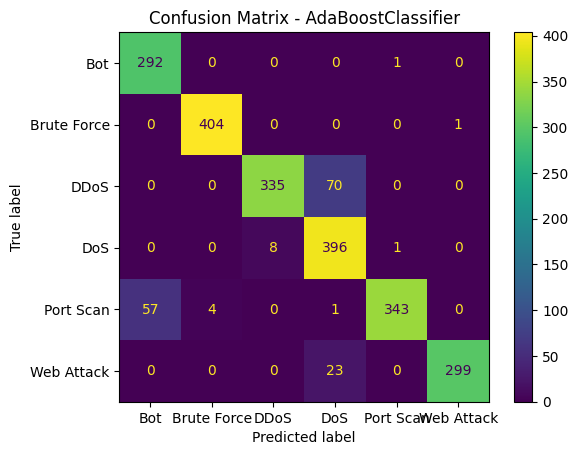

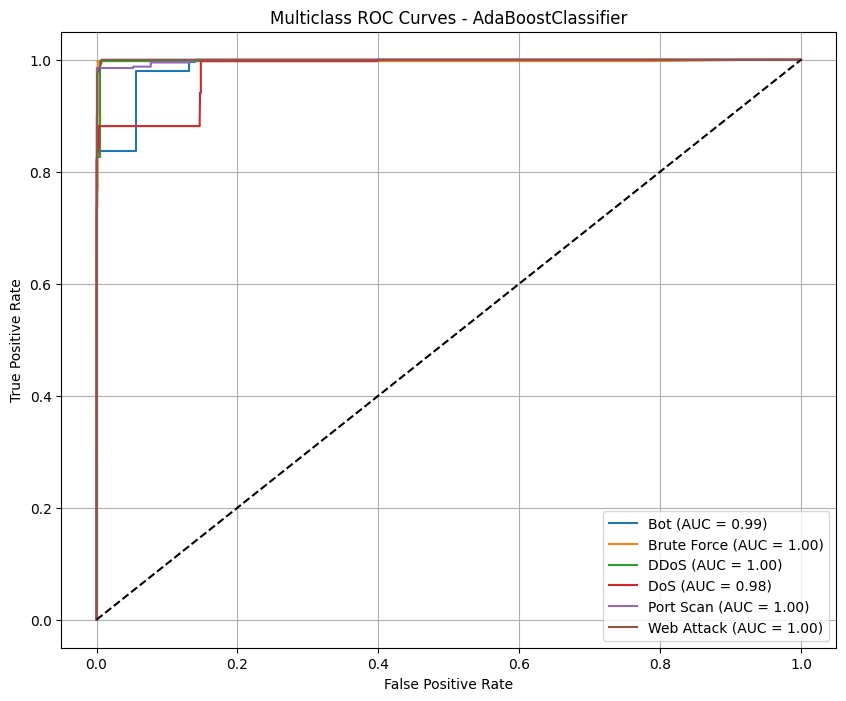

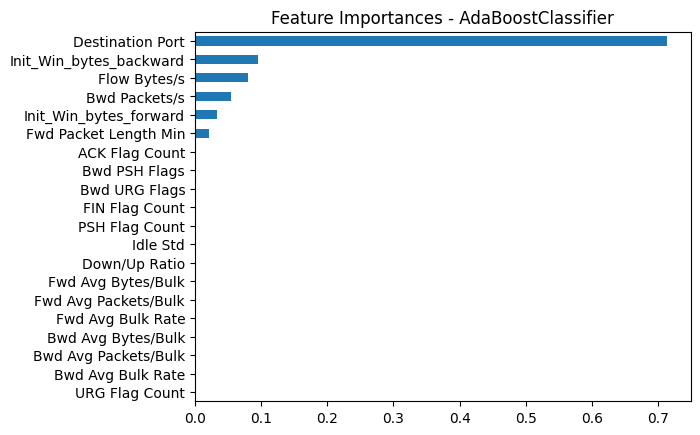


Test Set Performance Summary (Weighted Averages):


,accuracy,f1_weighted,precision_weighted,recall_weighted,prediction_time
Random Forest,0.999105,0.999105,0.999108,0.999105,0.028108
SVM,0.243848,0.177484,0.561863,0.243848,2.100557
Logistic Regression,0.631767,0.583634,0.673131,0.631767,0.003533
KNN,0.977181,0.977205,0.977357,0.977181,0.109563
Decision Tree,0.997315,0.997315,0.997331,0.997315,0.002734
AdaBoostClassifier,0.925727,0.926270,0.936293,0.925727,0.082827


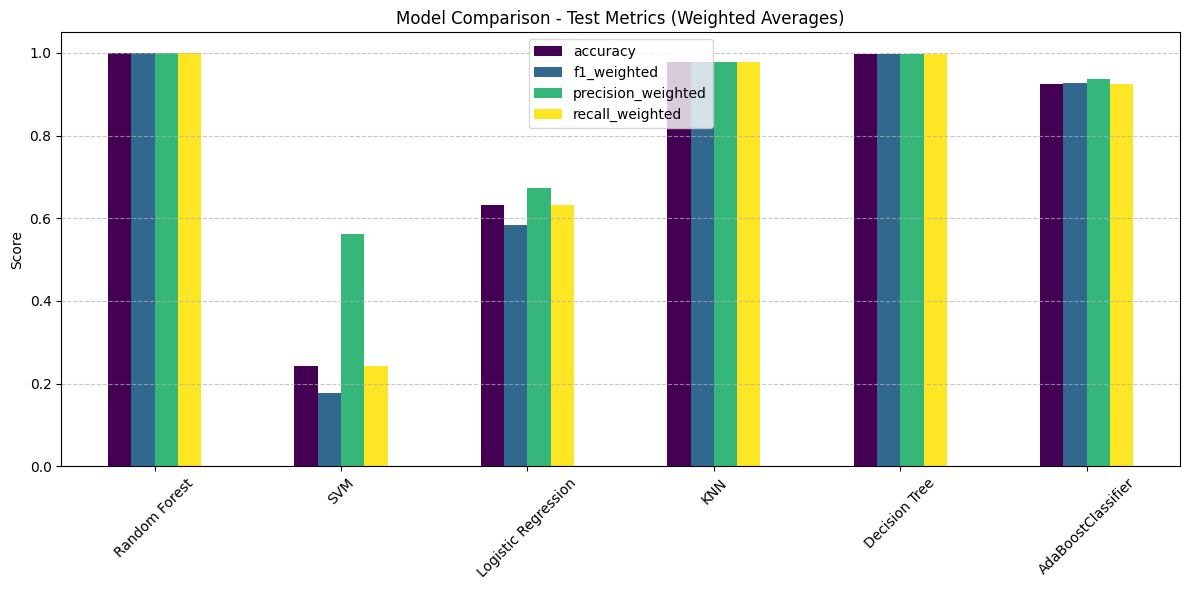

In [44]:
evaluate_all_on_test(trained_models, X_test, y_test, problem_type='multiclass')